#### *Please refer to the accompanying report*

## Mini Project Four

**File:** nsa325_mp4.ipnyb<br>
**Name:** Nishant Aswani<br>
**Professor:** Hwasoo Yeo<br>
**Assignment:** Mini Project 4<br>
**Course:** Machine Learning (ENGR-UH 4560) Fall 2019<br>
**Due:** Nov 21, 2019<br>

### About the Dataset

*`train.csv` will contain the details of a subset of the passengers on board (891 to be exact) and importantly, will reveal whether they survived or not, also known as the “ground truth”.*

*The `test.csv` dataset contains similar information but does not disclose the “ground truth” for each passenger. It’s your job to predict these outcomes.*

Source: https://www.kaggle.com/c/titanic

In [88]:
import numpy as np
import pandas as pd

# Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score





# To plot the graph embedded in the notebook
%matplotlib inline

## Data Exploration

In [2]:
titanic_df = pd.read_csv('./data/titanic/train.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
titanic_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

**We need to clean the null values to make this dataset more usable**

Cabin has too many missing values, so we will have to disregard that feature

In [4]:
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
titanic_df.shape

(891, 12)

## Data Adjustment and Cleaning

Let's convert some of the string features to integers so that we can use them for plotting and classification purposes

In [6]:
# mapping sex to binary value
sexes = sorted(titanic_df['Sex'].unique())
genders_mapping = dict(zip(sexes, range(0, len(sexes) + 1)))
genders_mapping
titanic_df['Sex_Val'] = titanic_df['Sex'].map(genders_mapping).astype(int)

In [7]:
# map embarked to values
embarked_locs = (titanic_df['Embarked'].unique())
embarked_locs_mapping = dict(zip(embarked_locs, 
                                 range(0, len(embarked_locs) + 1)))
embarked_locs_mapping

{'S': 0, 'C': 1, 'Q': 2, nan: 3}

In [8]:
titanic_df['Embarked_Val'] = titanic_df['Embarked'] \
                               .map(embarked_locs_mapping) \
                               .astype(int)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Val,Embarked_Val
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,0


We need to clean the embarked and age columns to get rid of null values

In [9]:
# replacing all null values in embarked with S (as it was the most used port)

if len(titanic_df[titanic_df['Embarked'].isnull()]) > 0:
    titanic_df.replace({'Embarked_Val' : 
                   { embarked_locs_mapping[np.nan] : embarked_locs_mapping['S'] 
                   }
               }, 
               inplace=True)

In [10]:
# fill missing age values with median

# To keep the age column intact, we make a copy of and call it AgeFill
# that we will use to fill in the missing ages:
titanic_df['AgeFill'] = titanic_df['Age']

# Populate AgeFill
titanic_df['AgeFill'] = titanic_df['AgeFill'] \
                        .groupby([titanic_df['Sex_Val'], titanic_df['Pclass']]) \
                        .apply(lambda x: x.fillna(x.median()))

In [11]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Val,Embarked_Val,AgeFill
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0,22.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1,38.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,26.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,0,35.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,0,35.0


## (Simple) Feature Engineering

In [12]:
# Making a FamilySize feature from parents and siblings features
titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Val,Embarked_Val,AgeFill,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0,22.0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1,38.0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,26.0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,0,35.0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,0,35.0,0


In [13]:
# Using dummy variables for embarked val to avoid any ordering
titanic_df = pd.concat([titanic_df, pd.get_dummies(titanic_df['Embarked_Val'], prefix='Embarked_Val')], axis=1)

In [61]:
titanic_df.head()

,Survived,Pclass,Fare,Sex_Val,AgeFill,FamilySize,Embarked_Val_0,Embarked_Val_1,Embarked_Val_2
0,0,3,7.2500,1,22.0,1,1,0,0
1,1,1,71.2833,0,38.0,1,0,1,0
2,1,3,7.9250,0,26.0,0,1,0,0
3,1,1,53.1000,0,35.0,1,1,0,0
4,0,3,8.0500,1,35.0,0,1,0,0


## Data Visualization

/home/niniack/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/niniack/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


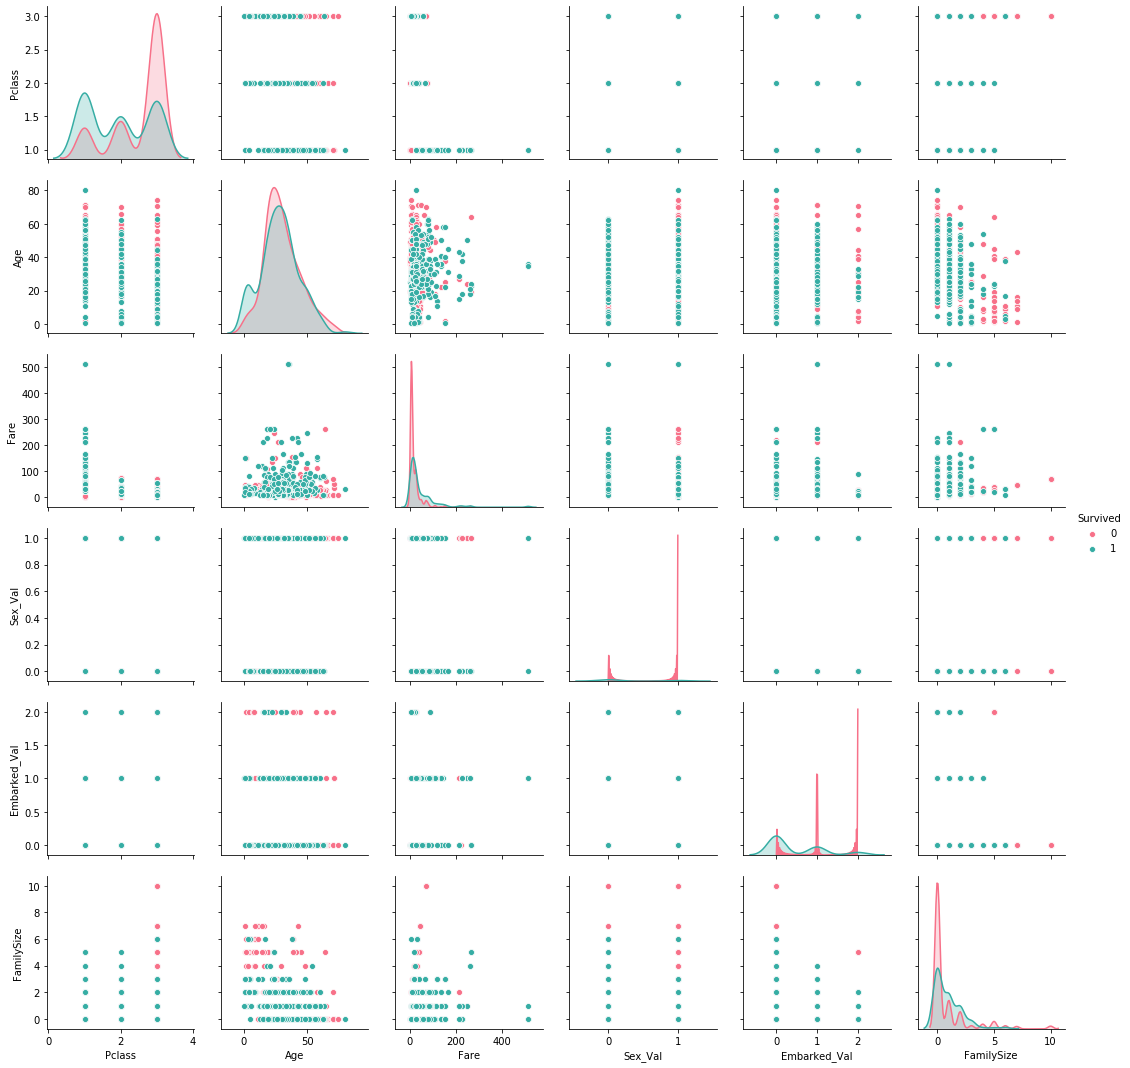

In [14]:
sns.pairplot(titanic_df, hue="Survived", palette="husl", vars=["Pclass", "Age", "Fare", "Sex_Val", "Embarked_Val", "FamilySize"])

In [15]:
titanic_df = titanic_df.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Embarked_Val', 'Age', 'SibSp', 'Parch', 'PassengerId'],axis=1)

In [16]:
titanic_df.head()

,Survived,Pclass,Fare,Sex_Val,AgeFill,FamilySize,Embarked_Val_0,Embarked_Val_1,Embarked_Val_2
0,0,3,7.2500,1,22.0,1,1,0,0
1,1,1,71.2833,0,38.0,1,0,1,0
2,1,3,7.9250,0,26.0,0,1,0,0
3,1,1,53.1000,0,35.0,1,1,0,0
4,0,3,8.0500,1,35.0,0,1,0,0


## Splitting Data (Train/Test)

In [17]:
train_data = titanic_df.values
train_data

array([[ 0.    ,  3.    ,  7.25  , ...,  1.    ,  0.    ,  0.    ],
       [ 1.    ,  1.    , 71.2833, ...,  0.    ,  1.    ,  0.    ],
       [ 1.    ,  3.    ,  7.925 , ...,  1.    ,  0.    ,  0.    ],
       ...,
       [ 0.    ,  3.    , 23.45  , ...,  1.    ,  0.    ,  0.    ],
       [ 1.    ,  1.    , 30.    , ...,  0.    ,  1.    ,  0.    ],
       [ 0.    ,  3.    ,  7.75  , ...,  0.    ,  0.    ,  1.    ]])

In [18]:
# Training data features, skip the first column 'Survived'
train_features = train_data[:, 1:]

# 'Survived' column values
train_target = train_data[:, 0]

# Split 80-20 train vs test data
train_x, test_x, train_y, test_y = train_test_split(train_features, 
                                                    train_target, 
                                                    test_size=0.20, 
                                                    random_state=0)

print (train_features.shape, train_target.shape)
print (train_x.shape, train_y.shape)
print (test_x.shape, test_y.shape)


(891, 8) (891,)
(712, 8) (712,)
(179, 8) (179,)


## Baseline Logistic Regression Model
We use the baseline models we produced in lab

In [19]:
# instantiate our model and fit the model with the training data
# LogisticRegression(solver = 'liblinear')

clf_lr = LogisticRegression(solver="liblinear").fit(train_x, train_y)
ypred_prob = clf_lr.predict_proba(train_x)
ypred = clf_lr.predict(train_x)

In [20]:
predicted_y = clf_lr.predict(test_x)
confusion_matrix = metrics.confusion_matrix(test_y, predicted_y)

In [21]:
print ("Confusion Matrix ", confusion_matrix)

print ("          Predicted")
print ("         |  0  |  1  |")
print ("         |-----|-----|")
print ("       0 | %3d | %3d |" % (confusion_matrix[0, 0],
                                   confusion_matrix[0, 1]))
print ("Actual   |-----|-----|")
print ("       1 | %3d | %3d |" % (confusion_matrix[1, 0],
                                   confusion_matrix[1, 1]))
print ("         |-----|-----|")

Confusion Matrix  [[95 15]
 [20 49]]
          Predicted
         |  0  |  1  |
         |-----|-----|
       0 |  95 |  15 |
Actual   |-----|-----|
       1 |  20 |  49 |
         |-----|-----|


In [22]:
TP = confusion_matrix[0, 0]
TN = confusion_matrix[1, 1]
ALL = np.sum(confusion_matrix)

calc_accuracy = (TP+TN)/ALL

accuracy = clf_lr.score(test_x, test_y)

In [23]:
print("Logistic Regression Model")
print("-------------------------")
print("Mean accuracy with test data:", accuracy)

Logistic Regression Model
-------------------------
Mean accuracy with test data: 0.8044692737430168


In [24]:
summary = metrics.classification_report(test_y, predicted_y, target_names=['Not Survived', 'Survived'])
print(summary)

              precision    recall  f1-score   support

Not Survived       0.83      0.86      0.84       110
    Survived       0.77      0.71      0.74        69

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



Text(0.5, 1.0, '')

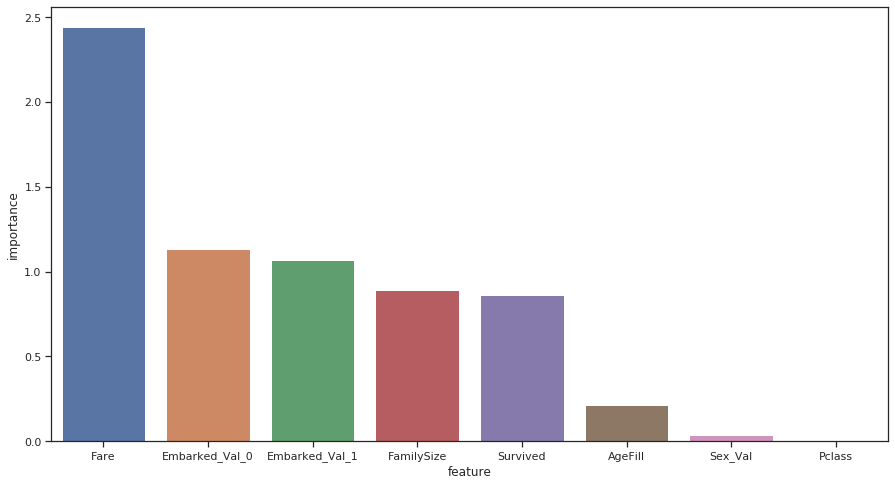

In [25]:
feature_importance_tuple = list(zip(titanic_df.columns,abs(clf_lr.coef_[0])))
df_feature_importances = pd.DataFrame(feature_importance_tuple, columns=['feature','importance']).sort_values('importance',ascending=False)
plt.figure(figsize=(15,8))
sns.set(style="white")
sns.set(style="ticks")
ax = sns.barplot(x="feature", y="importance", data=df_feature_importances)
ax.set_title("")

## Baseline SVM Model

In [26]:
clf_svm = svm.SVC(gamma = 'scale', kernel = 'linear').fit(train_x, train_y)
ypred = clf_svm.predict(train_x)

In [27]:
predict_y = clf_svm.predict(test_x)
confusion_matrix = metrics.confusion_matrix(test_y, predict_y)

In [28]:
print ("Confusion Matrix ", confusion_matrix)

print ("          Predicted")
print ("         |  0  |  1  |")
print ("         |-----|-----|")
print ("       0 | %3d | %3d |" % (confusion_matrix[0, 0],
                                   confusion_matrix[0, 1]))
print ("Actual   |-----|-----|")
print ("       1 | %3d | %3d |" % (confusion_matrix[1, 0],
                                   confusion_matrix[1, 1]))
print ("         |-----|-----|")

Confusion Matrix  [[92 18]
 [20 49]]
          Predicted
         |  0  |  1  |
         |-----|-----|
       0 |  92 |  18 |
Actual   |-----|-----|
       1 |  20 |  49 |
         |-----|-----|


In [29]:
TP = confusion_matrix[0,0]
TN = confusion_matrix[1,1]
ALL = np.sum(confusion_matrix)

calc_accuracy = (TP+TN)/ALL

accuracy = clf_svm.score(test_x, test_y)

In [30]:
print("Support Vector Machine")
print("-------------------------")
print("Mean accuracy with test data:", accuracy)

Support Vector Machine
-------------------------
Mean accuracy with test data: 0.7877094972067039


In [31]:
summary = classification_report(test_y, predict_y, target_names=['Not Survived', 'Survived'])
print(summary)

              precision    recall  f1-score   support

Not Survived       0.82      0.84      0.83       110
    Survived       0.73      0.71      0.72        69

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.79      0.79      0.79       179



Text(0.5, 1.0, '')

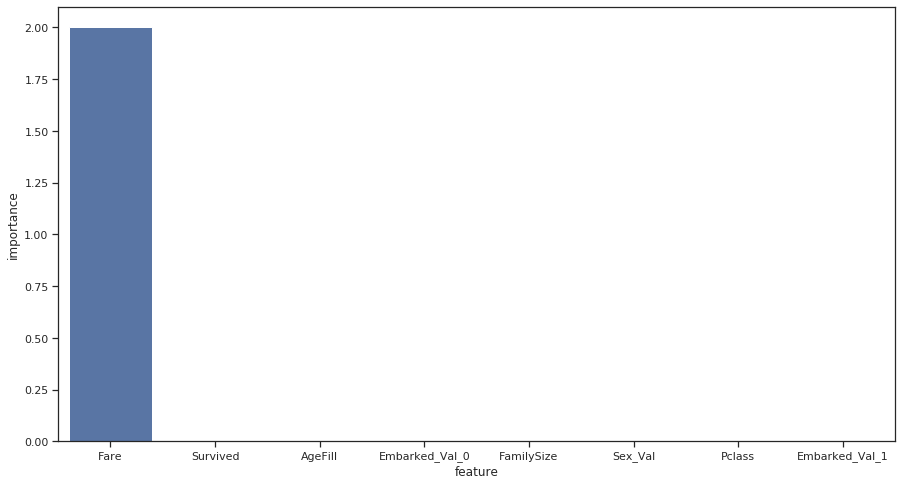

In [32]:
feature_importance_tuple = list(zip(titanic_df.columns,abs(clf_svm.coef_[0])))
df_feature_importances = pd.DataFrame(feature_importance_tuple, columns=['feature','importance']).sort_values('importance',ascending=False)
df_feature_importances
plt.figure(figsize=(15,8))
sns.set(style="white")
sns.set(style="ticks")
ax = sns.barplot(x="feature", y="importance", data=df_feature_importances)
ax.set_title("")

## Baseline Decision Tree Model (Random Forest)

In [136]:
## define a function for random forest
def randomForestClassifier(x_train, y_train, x_test, y_test):
  estimatorValues = [320, 350, 400, 500, 600, 700, 800, 900]
  clf = RandomForestClassifier(n_jobs = -1)
  hyper_parameter = {"n_estimators": estimatorValues}
  best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv=KFold(n_splits=3, random_state=1, shuffle=True), verbose=2)
  best_parameter.fit(x_train, y_train)
  estimators = best_parameter.best_params_["n_estimators"]
  print("estimators: " + str(estimators))

  #applying random forest with best hyper-parameter
  clf = RandomForestClassifier(n_estimators = estimators, n_jobs = -1, oob_score=True)
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_train)
  train_MAPE = mean_absolute_error(y_train, y_pred)/ (sum(y_train)/len(y_train))
  train_MSE = mean_squared_error(y_train, y_pred)
  y_pred = clf.predict(x_test)
  test_MAPE = mean_absolute_error(y_test, y_pred)/ (sum(y_test)/len(y_test))
  test_MSE = mean_squared_error(y_test, y_pred)
  train_accuracy = clf.score(x_train, y_train)
  test_accuracy = clf.score(x_test, y_test)

  feature_importances = clf.feature_importances_
  oob_score = clf.oob_score_

  
  return train_MAPE, train_MSE, test_MAPE, test_MSE, train_accuracy, test_accuracy, feature_importances, oob_score


In [137]:
#Random Forest Model
trainMAPE_rf, trainMSE_rf, testMAPE_rf, testMSE_rf, train_accuracy, test_accuracy, feature_importances_rf, oob_score_rf = randomForestClassifier(train_x, train_y, test_x, test_y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] n_estimators=320 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................. n_estimators=320, total=   0.4s
[CV] n_estimators=320 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ................................. n_estimators=320, total=   0.4s
[CV] n_estimators=320 ................................................
[CV] ................................. n_estimators=320, total=   0.4s
[CV] n_estimators=350 ................................................
[CV] ................................. n_estimators=350, total=   0.4s
[CV] n_estimators=350 ................................................
[CV] ................................. n_estimators=350, total=   0.4s
[CV] n_estimators=350 ................................................
[CV] ................................. n_estimators=350, total=   0.4s
[CV] n_estimators=400 ................................................
[CV] ................................. n_estimators=400, total=   0.5s
[CV] n_estimators=400 ................................................
[CV] ................................. n_estimators=400, total=   0.5s
[CV] n_estimators=400 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   15.1s finished


estimators: 320


In [138]:
print("Random Forest Classifier")
print("-------------------------")
print("Mean accuracy with test data:", test_accuracy)

Random Forest Classifier
-------------------------
Mean accuracy with test data: 0.8379888268156425


Text(0.5, 1.0, '')

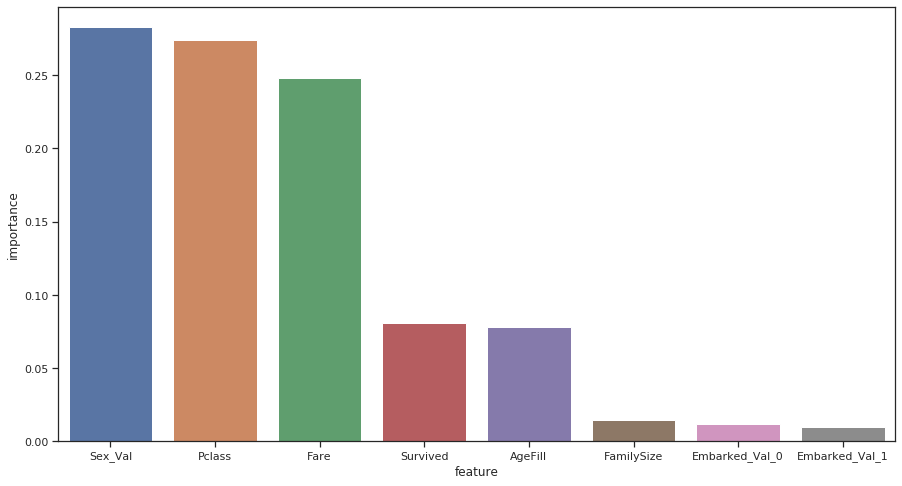

In [139]:
feature_importance_tuple = list(zip(titanic_df.columns,feature_importances_rf))
df_feature_importances = pd.DataFrame(feature_importance_tuple, columns=['feature','importance']).sort_values('importance',ascending=False)
df_feature_importances
plt.figure(figsize=(15,8))
sns.set(style="white")
sns.set(style="ticks")
ax = sns.barplot(x="feature", y="importance", data=df_feature_importances)
ax.set_title("")

We see that all of the graphs produce a different feature importance graph. We can attempt PCA to see if it helps in improving the accuracy of any of these models, especially SVM, seeing as it only uses one feature as an important one.

## Improvements in Random Forest Model (PCA, GridSearch, Pipeline)

In [37]:
# For PCA, First Need to Scale the Data.  
scaler1 = StandardScaler()
scaler1.fit(train_data)
feature_scaled = scaler1.transform(train_data)

# Now Apply PCA
pca1 = PCA(n_components=4)
pca1.fit(feature_scaled)
feature_scaled_pca = pca1.transform(feature_scaled)
print("shape of the scaled and 'PCA'ed features: ", np.shape(feature_scaled_pca))

shape of the scaled and 'PCA'ed features:  (891, 4)


In [38]:
feat_var = np.var(feature_scaled_pca, axis=0)
feat_var_rat = feat_var/(np.sum(feat_var))

print ("Variance Ratio of the 4 Principal Components Ananlysis: ", feat_var_rat)

Variance Ratio of the 4 Principal Components Ananlysis:  [0.35210453 0.25436854 0.22941117 0.16411577]


<class 'list'>


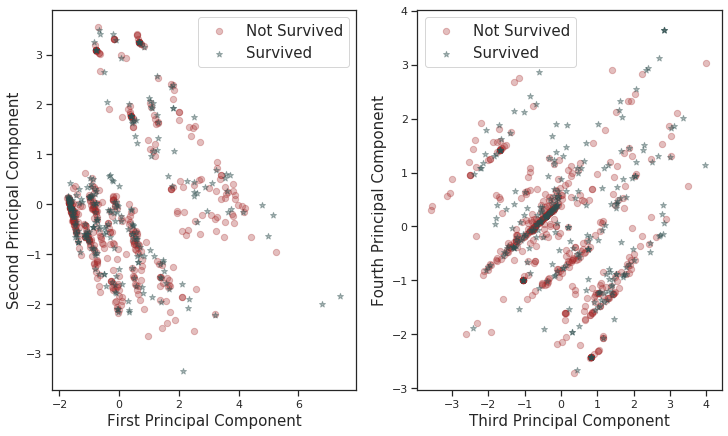

In [39]:
titanic_target_list = train_y.tolist()
print (type(titanic_target_list))

#print (cancer_target_list)
#print (type(yl))

feature_scaled_pca_X0 = feature_scaled_pca[:, 0]
feature_scaled_pca_X1 = feature_scaled_pca[:, 1]
feature_scaled_pca_X2 = feature_scaled_pca[:, 2]
feature_scaled_pca_X3 = feature_scaled_pca[:, 3]

labels = titanic_target_list
colordict = {0:'brown', 1:'darkslategray'}
piclabel = {0:'Not Survived', 1:'Survived'}
markers = {0:'o', 1:'*'}
alphas = {0:0.3, 1:0.4}

fig = plt.figure(figsize=(12, 7))
plt.subplot(1,2,1)
for l in np.unique(labels):
    ix = np.where(labels==l)
    plt.scatter(feature_scaled_pca_X0[ix], feature_scaled_pca_X1[ix], c=colordict[l], 
               label=piclabel[l], s=40, marker=markers[l], alpha=alphas[l])
plt.xlabel("First Principal Component", fontsize=15)
plt.ylabel("Second Principal Component", fontsize=15)

plt.legend(fontsize=15)

plt.subplot(1,2,2)
for l1 in np.unique(labels):
    ix1 = np.where(labels==l1)
    plt.scatter(feature_scaled_pca_X2[ix1], feature_scaled_pca_X3[ix1], c=colordict[l1], 
               label=piclabel[l1], s=40, marker=markers[l1], alpha=alphas[l1])
plt.xlabel("Third Principal Component", fontsize=15)
plt.ylabel("Fourth Principal Component", fontsize=15)

plt.legend(fontsize=15)


In [96]:
def randomForestClassifierPipeline(x_train, y_train, x_test, y_test):

    pipe_steps = [('scaler', StandardScaler()), ('pca', PCA()), ('rf', RandomForestClassifier(n_jobs = -1))]
    pipeline = Pipeline(pipe_steps)

    check_params= {
    'pca__n_components': [4], 
    'rf__n_estimators': [320, 350, 400, 500, 600, 700, 800, 900],
    'rf__max_depth': [5, 7, 9, 11, 13, 15]}
    

    grid_search = GridSearchCV(pipeline, 
                               check_params, 
                               cv=KFold(n_splits=3, random_state=1, shuffle=True),
                               verbose=2)
    
    grid_search.fit(x_train, y_train)
    grid_search.best_params_
    
    estimator = grid_search.best_params_["rf__n_estimators"]
    depth = grid_search.best_params_["rf__max_depth"]
    
    print("estimator: " + str(estimator))
    print("depth: " + str(depth))
    
    
    #applying random forest with best hyper-parameter
    pipe_steps = [('scaler', StandardScaler()), ('pca', PCA()), ('rf', RandomForestClassifier(n_jobs = -1, n_estimators = estimator, max_depth = depth, oob_score=True))]
    clf = Pipeline(pipe_steps)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_train)
    train_MAPE = mean_absolute_error(y_train, y_pred)/ (sum(y_train)/len(y_train))
    train_MSE = mean_squared_error(y_train, y_pred)
    y_pred = clf.predict(x_test)
    test_MAPE = mean_absolute_error(y_test, y_pred)/ (sum(y_test)/len(y_test))
    test_MSE = mean_squared_error(y_test, y_pred)
    train_accuracy = clf.score(x_train, y_train)
    test_accuracy = clf.score(x_test, y_test)

    feature_importances = clf['rf'].feature_importances_
    oob_score = clf['rf'].oob_score_


    return train_MAPE, train_MSE, test_MAPE, test_MSE, train_accuracy, test_accuracy, feature_importances, oob_score


#   values = [320, 350, 400, 500, 600, 700, 800, 900]
#   clf = RandomForestClassifier(n_jobs = -1)
#   hyper_parameter = {"n_estimators": values}
#   best_parameter = GridSearchCV(pipeline, hyper_parameter, scoring = "neg_mean_absolute_error", cv=KFold(n_splits=3, random_state=1, shuffle=True), verbose=2)
#   best_parameter.fit(x_train, y_train)
#   estimators = best_parameter.best_params_["n_estimators"]
#   print("estimators: " + str(estimators))






In [97]:
#Random Forest Model
trainMAPE_rf, trainMSE_rf, testMAPE_rf, testMSE_rf, train_accuracy, test_accuracy, feature_importances_rf, oob_score_rf = randomForestClassifierPipeline(train_x, train_y, test_x, test_y)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] pca__n_components=4, rf__max_depth=5, rf__n_estimators=320 ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  pca__n_components=4, rf__max_depth=5, rf__n_estimators=320, total=   1.8s
[CV] pca__n_components=4, rf__max_depth=5, rf__n_estimators=320 ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV]  pca__n_components=4, rf__max_depth=5, rf__n_estimators=320, total=   0.5s
[CV] pca__n_components=4, rf__max_depth=5, rf__n_estimators=320 ......
[CV]  pca__n_components=4, rf__max_depth=5, rf__n_estimators=320, total=   0.6s
[CV] pca__n_components=4, rf__max_depth=5, rf__n_estimators=350 ......
[CV]  pca__n_components=4, rf__max_depth=5, rf__n_estimators=350, total=   0.5s
[CV] pca__n_components=4, rf__max_depth=5, rf__n_estimators=350 ......
[CV]  pca__n_components=4, rf__max_depth=5, rf__n_estimators=350, total=   0.5s
[CV] pca__n_components=4, rf__max_depth=5, rf__n_estimators=350 ......
[CV]  pca__n_components=4, rf__max_depth=5, rf__n_estimators=350, total=   0.5s
[CV] pca__n_components=4, rf__max_depth=5, rf__n_estimators=400 ......
[CV]  pca__n_components=4, rf__max_depth=5, rf__n_estimators=400, total=   0.6s
[CV] pca__n_components=4, rf__max_depth=5, rf__n_estimators=400 ......
[CV]  pca__n_components=4, rf__max_depth=5, rf__n_estimators=400, total=   0.5s
[CV] pca__n_co

[CV]  pca__n_components=4, rf__max_depth=9, rf__n_estimators=400, total=   0.5s
[CV] pca__n_components=4, rf__max_depth=9, rf__n_estimators=500 ......
[CV]  pca__n_components=4, rf__max_depth=9, rf__n_estimators=500, total=   0.6s
[CV] pca__n_components=4, rf__max_depth=9, rf__n_estimators=500 ......
[CV]  pca__n_components=4, rf__max_depth=9, rf__n_estimators=500, total=   0.6s
[CV] pca__n_components=4, rf__max_depth=9, rf__n_estimators=500 ......
[CV]  pca__n_components=4, rf__max_depth=9, rf__n_estimators=500, total=   0.6s
[CV] pca__n_components=4, rf__max_depth=9, rf__n_estimators=600 ......
[CV]  pca__n_components=4, rf__max_depth=9, rf__n_estimators=600, total=   0.8s
[CV] pca__n_components=4, rf__max_depth=9, rf__n_estimators=600 ......
[CV]  pca__n_components=4, rf__max_depth=9, rf__n_estimators=600, total=   0.6s
[CV] pca__n_components=4, rf__max_depth=9, rf__n_estimators=600 ......
[CV]  pca__n_components=4, rf__max_depth=9, rf__n_estimators=600, total=   0.6s
[CV] pca__n_co

[CV]  pca__n_components=4, rf__max_depth=13, rf__n_estimators=700, total=   0.7s
[CV] pca__n_components=4, rf__max_depth=13, rf__n_estimators=700 .....
[CV]  pca__n_components=4, rf__max_depth=13, rf__n_estimators=700, total=   0.8s
[CV] pca__n_components=4, rf__max_depth=13, rf__n_estimators=700 .....
[CV]  pca__n_components=4, rf__max_depth=13, rf__n_estimators=700, total=   0.7s
[CV] pca__n_components=4, rf__max_depth=13, rf__n_estimators=800 .....
[CV]  pca__n_components=4, rf__max_depth=13, rf__n_estimators=800, total=   1.0s
[CV] pca__n_components=4, rf__max_depth=13, rf__n_estimators=800 .....
[CV]  pca__n_components=4, rf__max_depth=13, rf__n_estimators=800, total=   0.9s
[CV] pca__n_components=4, rf__max_depth=13, rf__n_estimators=800 .....
[CV]  pca__n_components=4, rf__max_depth=13, rf__n_estimators=800, total=   1.0s
[CV] pca__n_components=4, rf__max_depth=13, rf__n_estimators=900 .....
[CV]  pca__n_components=4, rf__max_depth=13, rf__n_estimators=900, total=   1.1s
[CV] pc

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  1.7min finished


estimator: 800
depth: 5


In [98]:
print(test_accuracy)

0.8268156424581006


Text(0.5, 1.0, '')

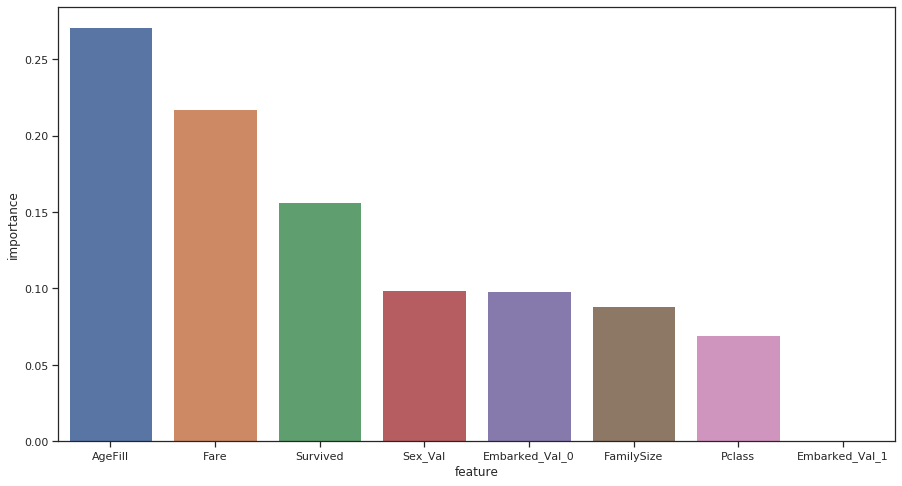

In [99]:
feature_importance_tuple = list(zip(titanic_df.columns,feature_importances_rf))
df_feature_importances = pd.DataFrame(feature_importance_tuple, columns=['feature','importance']).sort_values('importance',ascending=False)
df_feature_importances
plt.figure(figsize=(15,8))
sns.set(style="white")
sns.set(style="ticks")
ax = sns.barplot(x="feature", y="importance", data=df_feature_importances)
ax.set_title("")

## Ensemble Learning

In [133]:
from sklearn.ensemble import VotingClassifier

estimators = []

model1 = LogisticRegression(solver="liblinear")
estimators.append(('logistic', model1))
model2 = svm.SVC(gamma = 'scale', kernel = 'linear')
estimators.append(('svm', model2))
model3= RandomForestClassifier(n_jobs = -1, n_estimators = 800, max_depth = 5, oob_score=True)
estimators.append(('rf', model3))

# create the ensemble model
ensemble = VotingClassifier(estimators, weights=[1,1,2])
ensemble.fit(train_x, train_y)
test_accuracy_ensemble = ensemble.score(test_x, test_y)

In [134]:
print(test_accuracy_ensemble)

0.8156424581005587


In [140]:
ensemble.named_estimators_['rf'].score(test_x, test_y)

0.8324022346368715

Text(0.5, 1.0, '')

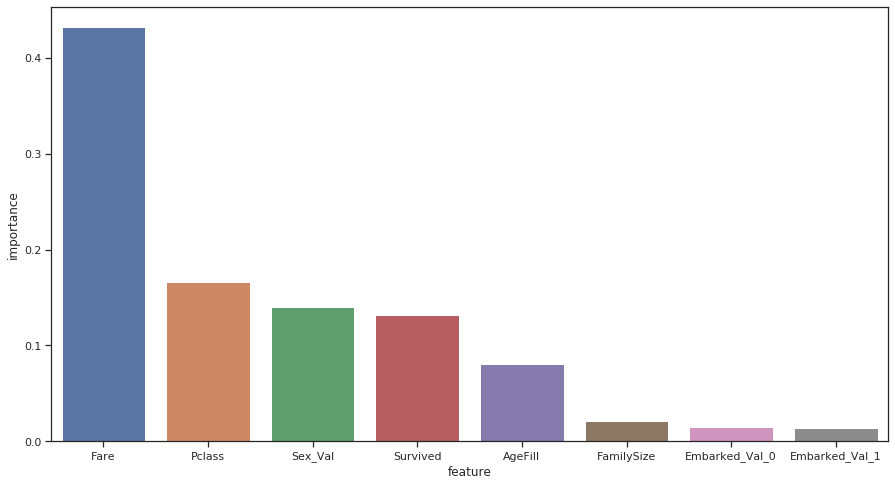

In [135]:

feature_importance_tuple = list(zip(titanic_df.columns,ensemble.named_estimators_['rf'].feature_importances_))
df_feature_importances = pd.DataFrame(feature_importance_tuple, columns=['feature','importance']).sort_values('importance',ascending=False)
df_feature_importances
plt.figure(figsize=(15,8))
sns.set(style="white")
sns.set(style="ticks")
ax = sns.barplot(x="feature", y="importance", data=df_feature_importances)
ax.set_title("")